In [9]:
#Importing necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import featuretools as ft


In [10]:
#Importing the renewal dataset
df = pd.read_excel('Renewal_01_12_2019.xlsx')

In [11]:
df.head()

,AcctId,Tenure,AttendancePercentage,Zip,CountyName,State,DistanceFromStadium,NumberOfCalls,NumberOfVoicemails,NumberOfEmails,...,BaseNumSeats,BaseSection(s),BaseRow(s),BasePriceCode(s),RenewedRevenue,RenewedNumSeats,RenewedSection(s),RenewedRow(s),RenewedPriceCode(s),RenewalDate
0,100023,35,84,46256,MARION COUNTY,IN,2.545216,0,1,1,...,7,"451, 451, 453","17, 18, 3","H, H, H",0,0,NaN,NaN,NaN,NaT
1,100045,35,95,46140,HANCOCK COUNTY,IN,20.249773,0,1,1,...,2,206,4,F,2280,2,206,4,F,2018-12-04
2,100078,25,100,46240,MARION COUNTY,IN,2.545216,0,2,0,...,2,418,1,F,2280,2,418,1,F,2018-12-31
3,100144,33,100,46250,MARION COUNTY,IN,2.545216,1,0,0,...,4,210,7,D,5920,4,210,7,D,2018-11-07
4,100221,31,100,46952,GRANT COUNTY,IN,59.189328,0,0,0,...,4,108,16,E,5360,4,108,16,E,2018-11-19


In [12]:
df = df.assign(rrate =df.RenewedRevenue / df.BaseRevenue)


In [13]:
df.head()

,AcctId,Tenure,AttendancePercentage,Zip,CountyName,State,DistanceFromStadium,NumberOfCalls,NumberOfVoicemails,NumberOfEmails,...,BaseSection(s),BaseRow(s),BasePriceCode(s),RenewedRevenue,RenewedNumSeats,RenewedSection(s),RenewedRow(s),RenewedPriceCode(s),RenewalDate,rrate
0,100023,35,84,46256,MARION COUNTY,IN,2.545216,0,1,1,...,"451, 451, 453","17, 18, 3","H, H, H",0,0,NaN,NaN,NaN,NaT,0.0
1,100045,35,95,46140,HANCOCK COUNTY,IN,20.249773,0,1,1,...,206,4,F,2280,2,206,4,F,2018-12-04,1.0
2,100078,25,100,46240,MARION COUNTY,IN,2.545216,0,2,0,...,418,1,F,2280,2,418,1,F,2018-12-31,1.0
3,100144,33,100,46250,MARION COUNTY,IN,2.545216,1,0,0,...,210,7,D,5920,4,210,7,D,2018-11-07,1.0
4,100221,31,100,46952,GRANT COUNTY,IN,59.189328,0,0,0,...,108,16,E,5360,4,108,16,E,2018-11-19,1.0


In [14]:
#Changing renewal value to binary
df['rrate'].value_counts()

df['rrate'] = np.where(df['rrate']>0, 1, 0)
df['rrate'].value_counts()

dc = df[['Tenure','AttendancePercentage', 'NumberOfCalls','NumberOfEmails','rrate']]

df = df.astype({"Tenure": float, "AttendancePercentage": float})
df.info()

#df.loc[df['rrate']==0,['rrate'] ].count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10271 entries, 0 to 10270
Data columns (total 22 columns):
AcctId                  10271 non-null int64
Tenure                  10271 non-null float64
AttendancePercentage    10271 non-null float64
Zip                     10267 non-null object
CountyName              10017 non-null object
State                   10017 non-null object
DistanceFromStadium     10017 non-null float64
NumberOfCalls           10271 non-null int64
NumberOfVoicemails      10271 non-null int64
NumberOfEmails          10271 non-null int64
BaseRevenue             10271 non-null int64
BaseNumSeats            10271 non-null int64
BaseSection(s)          10271 non-null object
BaseRow(s)              10271 non-null object
BasePriceCode(s)        10271 non-null object
RenewedRevenue          10271 non-null int64
RenewedNumSeats         10271 non-null int64
RenewedSection(s)       6072 non-null object
RenewedRow(s)           6072 non-null object
RenewedPriceCode(s)     

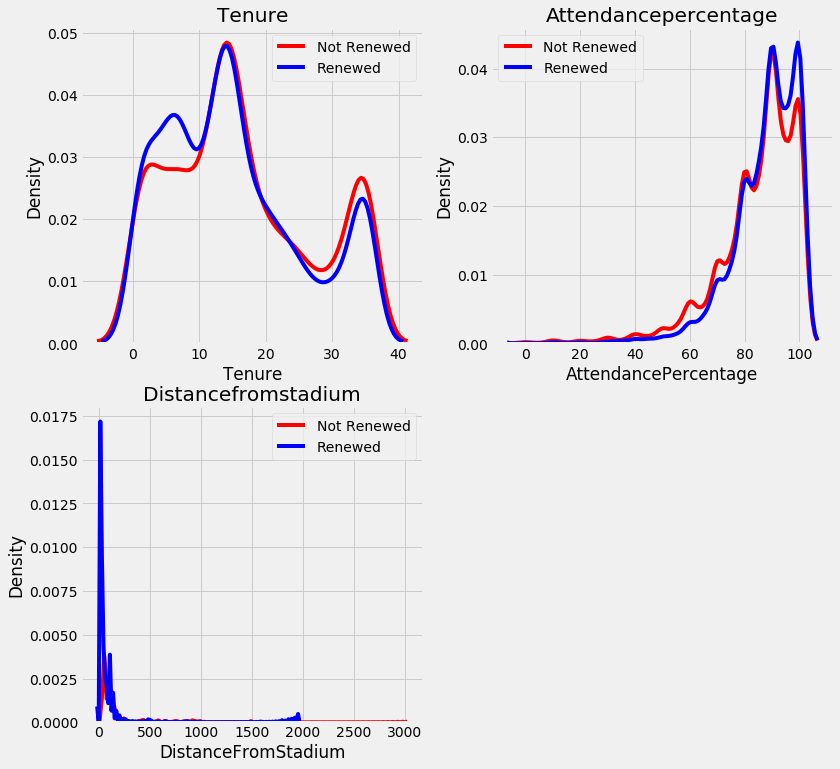

In [15]:
from collections import OrderedDict

plt.figure(figsize = (12, 5))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({0: 'red', 1: 'blue'})
poverty_mapping = OrderedDict({0: 'Not Renewed', 1: 'Renewed'})

# Iterate through the float columns
for i, col in enumerate(df.select_dtypes('float')):
    ax = plt.subplot(2, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(df.loc[df['rrate'] == poverty_level, col].dropna(),ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(str(col.capitalize())); plt.xlabel(str(col)); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

0    4199
1    6072
Name: rrate, dtype: int64

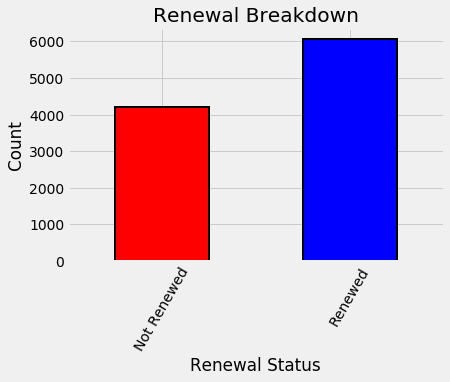

In [16]:
train_labels = df.loc[(df['rrate'].notnull()), ['rrate', 'AcctId']]

# Value counts of target
label_counts = train_labels['rrate'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (6, 4), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Renewal Status'); plt.ylabel('Count'); 

plt.xticks([x  for x in poverty_mapping.keys()],list(poverty_mapping.values()), rotation = 60)
ax.set_xticks(range(2))
plt.title('Renewal Breakdown');

label_counts

In [17]:
##Substituting the values of Base Price Code and adding the values to get new feature
mapping = {"D": 12, "E": 11, "F":10, "G":9,"H":8,"I":7,"J":6,"K":5,"L":4,"M":3, "N":2,"O":1, "Z":1}
df["BasePriceCode(s)"]= df["BasePriceCode(s)"].str.split(",",expand = True)
df["BasePriceCode(s)"]= df["BasePriceCode(s)"].replace(mapping).astype(np.int32)

df.head()

,AcctId,Tenure,AttendancePercentage,Zip,CountyName,State,DistanceFromStadium,NumberOfCalls,NumberOfVoicemails,NumberOfEmails,...,BaseSection(s),BaseRow(s),BasePriceCode(s),RenewedRevenue,RenewedNumSeats,RenewedSection(s),RenewedRow(s),RenewedPriceCode(s),RenewalDate,rrate
0,100023,35.0,84.0,46256,MARION COUNTY,IN,2.545216,0,1,1,...,"451, 451, 453","17, 18, 3",8,0,0,NaN,NaN,NaN,NaT,0
1,100045,35.0,95.0,46140,HANCOCK COUNTY,IN,20.249773,0,1,1,...,206,4,10,2280,2,206,4,F,2018-12-04,1
2,100078,25.0,100.0,46240,MARION COUNTY,IN,2.545216,0,2,0,...,418,1,10,2280,2,418,1,F,2018-12-31,1
3,100144,33.0,100.0,46250,MARION COUNTY,IN,2.545216,1,0,0,...,210,7,12,5920,4,210,7,D,2018-11-07,1
4,100221,31.0,100.0,46952,GRANT COUNTY,IN,59.189328,0,0,0,...,108,16,11,5360,4,108,16,E,2018-11-19,1


In [18]:
##Taking necessary columns 
df['BasePriceCode(s)'].isna().sum()

dc = df[['AcctId','Tenure','AttendancePercentage','DistanceFromStadium', 'NumberOfCalls','NumberOfVoicemails','NumberOfEmails','BaseRevenue','BaseNumSeats','BasePriceCode(s)','rrate']]

dc = dc.dropna()
for i in dc.columns:
    print(dc[i].isna().sum())
    
dc.info()

0
0
0
0
0
0
0
0
0
0
0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10017 entries, 0 to 10269
Data columns (total 11 columns):
AcctId                  10017 non-null int64
Tenure                  10017 non-null float64
AttendancePercentage    10017 non-null float64
DistanceFromStadium     10017 non-null float64
NumberOfCalls           10017 non-null int64
NumberOfVoicemails      10017 non-null int64
NumberOfEmails          10017 non-null int64
BaseRevenue             10017 non-null int64
BaseNumSeats            10017 non-null int64
BasePriceCode(s)        10017 non-null int32
rrate                   10017 non-null int32
dtypes: float64(3), int32(2), int64(6)
memory usage: 860.8 KB


In [19]:
# Create correlation matrix
corr_matrix = dc.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.80)]

print(f'There are {len(to_drop)} correlated columns to remove.')
print(to_drop)

There are 1 correlated columns to remove.
['BaseNumSeats']


In [20]:
dc.columns

Index(['AcctId', 'Tenure', 'AttendancePercentage', 'DistanceFromStadium',
       'NumberOfCalls', 'NumberOfVoicemails', 'NumberOfEmails', 'BaseRevenue',
       'BaseNumSeats', 'BasePriceCode(s)', 'rrate'],
      dtype='object')

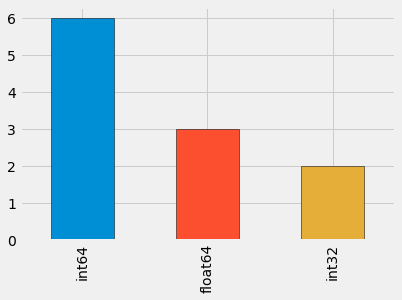

In [21]:
v_ordered = ['NumberOfCalls', 'NumberOfVoicemails', 'NumberOfEmails','BaseNumSeats', 'BasePriceCode(s)']
v_cont = ['Tenure', 'AttendancePercentage', 'DistanceFromStadium']
dc.dtypes.value_counts().plot.bar(edgecolor = 'k')

In [22]:
# dropping any duplicates ids
dc = dc.drop_duplicates(subset='AcctId')

In [23]:
es = ft.EntitySet(id = 'renewal')
es.entity_from_dataframe(entity_id = 'data',dataframe = dc,index = 'AcctId')

Entityset: renewal
  Entities:
    data [Rows: 9997, Columns: 11]
  Relationships:
    No relationships

In [24]:
#Normalizing the data 
es.normalize_entity(base_entity_id="data",
                    new_entity_id="n_seats",
                    index="BaseNumSeats")

es.normalize_entity(base_entity_id="data",
                    new_entity_id="price",
                    index="BasePriceCode(s)")

Entityset: renewal
  Entities:
    data [Rows: 9997, Columns: 11]
    n_seats [Rows: 40, Columns: 1]
    price [Rows: 12, Columns: 1]
  Relationships:
    data.BaseNumSeats -> n_seats.BaseNumSeats
    data.BasePriceCode(s) -> price.BasePriceCode(s)

In [25]:
# es.plot()

In [26]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
                                       target_entity = 'data',
                                       max_depth = 2,max_features = 1000, 
                                       verbose = 1, 
                                       n_jobs = -1, 
                                       chunk_size = 100)

Built 112 features
EntitySet scattered to workers in 7.554 seconds
Elapsed: 00:16 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 100/100 chunks


In [27]:
feature_matrix.head()

,Tenure,AttendancePercentage,DistanceFromStadium,NumberOfCalls,NumberOfVoicemails,NumberOfEmails,BaseRevenue,BaseNumSeats,BasePriceCode(s),rrate,...,price.MEAN(data.AttendancePercentage),price.MEAN(data.DistanceFromStadium),price.MEAN(data.NumberOfCalls),price.MEAN(data.NumberOfVoicemails),price.MEAN(data.NumberOfEmails),price.MEAN(data.BaseRevenue),price.MEAN(data.rrate),price.COUNT(data),price.NUM_UNIQUE(data.BaseNumSeats),price.MODE(data.BaseNumSeats)
AcctId,,,,,,,,,,,,,,,,,,,,,
100023,35.0,84.0,2.545216,0,1,1,6440,7,8,0,...,85.290957,55.196600,0.508519,0.693316,0.433814,2568.712975,0.571429,763,13,2
100045,35.0,95.0,20.249773,0,1,1,2280,2,10,1,...,86.832778,53.658722,0.627582,0.662891,0.450366,3353.937375,0.603598,1501,19,2
100078,25.0,100.0,2.545216,0,2,0,2280,2,10,1,...,86.832778,53.658722,0.627582,0.662891,0.450366,3353.937375,0.603598,1501,19,2
100144,33.0,100.0,2.545216,1,0,0,5920,4,12,1,...,88.410240,57.518061,0.726296,0.747155,0.481037,4933.791403,0.583439,1582,22,2
100221,31.0,100.0,59.189328,0,0,0,5360,4,11,1,...,86.768997,63.537042,0.619301,0.623860,0.438450,3878.559271,0.604103,1316,16,2


In [28]:
drop_cols = []
for col in feature_matrix:
    if col == 'rrate':
        pass
    else:
        if 'rrate' in col:
            drop_cols.append(col)
            
print(drop_cols)            


['n_seats.SUM(data.rrate)', 'n_seats.STD(data.rrate)', 'n_seats.MAX(data.rrate)', 'n_seats.SKEW(data.rrate)', 'n_seats.MIN(data.rrate)', 'n_seats.MEAN(data.rrate)', 'price.SUM(data.rrate)', 'price.STD(data.rrate)', 'price.MAX(data.rrate)', 'price.SKEW(data.rrate)', 'price.MIN(data.rrate)', 'price.MEAN(data.rrate)']


In [29]:
feature_matrix = feature_matrix[[x for x in feature_matrix if x not in drop_cols]]         
feature_matrix.head()

,Tenure,AttendancePercentage,DistanceFromStadium,NumberOfCalls,NumberOfVoicemails,NumberOfEmails,BaseRevenue,BaseNumSeats,BasePriceCode(s),rrate,...,price.MEAN(data.Tenure),price.MEAN(data.AttendancePercentage),price.MEAN(data.DistanceFromStadium),price.MEAN(data.NumberOfCalls),price.MEAN(data.NumberOfVoicemails),price.MEAN(data.NumberOfEmails),price.MEAN(data.BaseRevenue),price.COUNT(data),price.NUM_UNIQUE(data.BaseNumSeats),price.MODE(data.BaseNumSeats)
AcctId,,,,,,,,,,,,,,,,,,,,,
100023,35.0,84.0,2.545216,0,1,1,6440,7,8,0,...,12.965924,85.290957,55.196600,0.508519,0.693316,0.433814,2568.712975,763,13,2
100045,35.0,95.0,20.249773,0,1,1,2280,2,10,1,...,15.246502,86.832778,53.658722,0.627582,0.662891,0.450366,3353.937375,1501,19,2
100078,25.0,100.0,2.545216,0,2,0,2280,2,10,1,...,15.246502,86.832778,53.658722,0.627582,0.662891,0.450366,3353.937375,1501,19,2
100144,33.0,100.0,2.545216,1,0,0,5920,4,12,1,...,19.457016,88.410240,57.518061,0.726296,0.747155,0.481037,4933.791403,1582,22,2
100221,31.0,100.0,59.189328,0,0,0,5360,4,11,1,...,14.765198,86.768997,63.537042,0.619301,0.623860,0.438450,3878.559271,1316,16,2


In [30]:
corr_matrix = feature_matrix.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] >= 0.80)]

print('There are {} columns with >= 0.80 correlation.'.format(len(to_drop)))
to_drop

There are 48 columns with >= 0.80 correlation.


['BaseNumSeats',
 'n_seats.SUM(data.AttendancePercentage)',
 'n_seats.SUM(data.DistanceFromStadium)',
 'n_seats.SUM(data.NumberOfCalls)',
 'n_seats.SUM(data.NumberOfVoicemails)',
 'n_seats.SUM(data.NumberOfEmails)',
 'n_seats.SUM(data.BaseRevenue)',
 'n_seats.STD(data.BaseRevenue)',
 'n_seats.MAX(data.DistanceFromStadium)',
 'n_seats.MAX(data.NumberOfEmails)',
 'n_seats.MAX(data.BaseRevenue)',
 'n_seats.SKEW(data.Tenure)',
 'n_seats.SKEW(data.DistanceFromStadium)',
 'n_seats.SKEW(data.NumberOfCalls)',
 'n_seats.MIN(data.AttendancePercentage)',
 'n_seats.MIN(data.NumberOfVoicemails)',
 'n_seats.MIN(data.BaseRevenue)',
 'n_seats.MEAN(data.Tenure)',
 'n_seats.MEAN(data.DistanceFromStadium)',
 'n_seats.MEAN(data.NumberOfCalls)',
 'n_seats.MEAN(data.NumberOfVoicemails)',
 'n_seats.MEAN(data.NumberOfEmails)',
 'n_seats.MEAN(data.BaseRevenue)',
 'n_seats.COUNT(data)',
 'price.SUM(data.AttendancePercentage)',
 'price.SUM(data.DistanceFromStadium)',
 'price.SUM(data.NumberOfCalls)',
 'price.SUM

In [31]:
feature_matrix = feature_matrix[[x for x in feature_matrix if x not in to_drop]]

In [32]:
feature_matrix.head()

,Tenure,AttendancePercentage,DistanceFromStadium,NumberOfCalls,NumberOfVoicemails,NumberOfEmails,BaseRevenue,BasePriceCode(s),rrate,n_seats.SUM(data.Tenure),...,price.SKEW(data.NumberOfVoicemails),price.MIN(data.Tenure),price.MIN(data.AttendancePercentage),price.MIN(data.DistanceFromStadium),price.MIN(data.NumberOfCalls),price.MIN(data.NumberOfVoicemails),price.MIN(data.NumberOfEmails),price.MIN(data.BaseRevenue),price.MEAN(data.NumberOfEmails),price.MODE(data.BaseNumSeats)
AcctId,,,,,,,,,,,,,,,,,,,,,
100023,35.0,84.0,2.545216,0,1,1,6440,8,0,913.0,...,1.223312,1.0,25.0,2.545216,0,0,0,920,0.433814,2
100045,35.0,95.0,20.249773,0,1,1,2280,10,1,86612.0,...,1.331707,1.0,10.0,2.545216,0,0,0,1140,0.450366,2
100078,25.0,100.0,2.545216,0,2,0,2280,10,1,86612.0,...,1.331707,1.0,10.0,2.545216,0,0,0,1140,0.450366,2
100144,33.0,100.0,2.545216,1,0,0,5920,12,1,42427.0,...,1.053813,1.0,10.0,2.545216,0,0,0,318,0.481037,2
100221,31.0,100.0,59.189328,0,0,0,5360,11,1,42427.0,...,1.294768,1.0,0.0,2.545216,0,0,0,1340,0.438450,2


In [33]:
#taking out the renewal column
train_labels = np.array(feature_matrix.pop('rrate')).reshape((-1,))
feature_matrix.head()

train_labels


array([0, 1, 1, ..., 0, 1, 0])

In [34]:
train_set = feature_matrix.copy()

In [35]:
#Importing necessary modeling algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [36]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_set = pipeline.fit_transform(train_set)

E:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [37]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = 'f1')


In [38]:
cv_score.mean()

0.717397073120685

In [39]:
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = 'precision')
cv_score.mean()

0.720721379311251

In [40]:
model.fit(train_set, train_labels)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances

,feature,importance
0,Tenure,0.190011
1,AttendancePercentage,0.147708
2,DistanceFromStadium,0.168237
3,NumberOfCalls,0.068715
4,NumberOfVoicemails,0.148263
5,NumberOfEmails,0.125021
6,BaseRevenue,0.020289
7,BasePriceCode(s),0.006191
8,n_seats.SUM(data.Tenure),0.003688
9,n_seats.STD(data.Tenure),0.003686


In [41]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

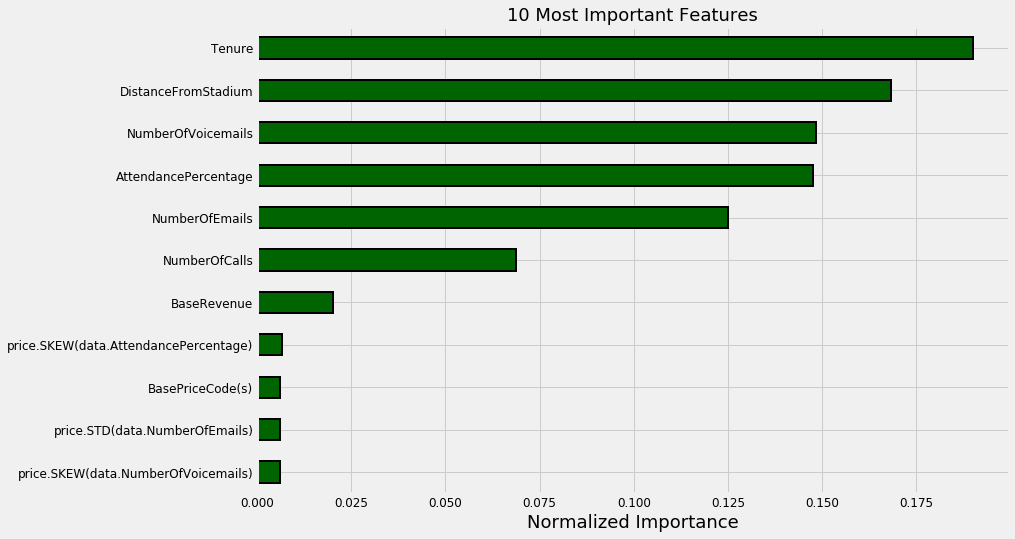

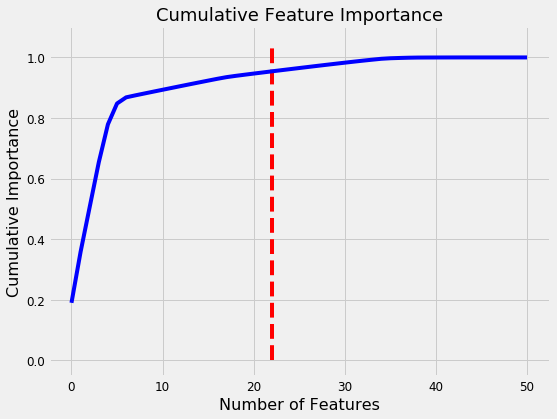

22 features required for 95% of cumulative importance.


In [42]:
#Feature importance based on tree based classifier 
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

In [54]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring='precision', n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [44]:
model_results = cv_model(train_set, train_labels, LinearSVC(), 
                         'LSVC', model_results)

10 Fold CV Score: 0.78629 with std: 0.02648


In [45]:
model_results = cv_model(train_set, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.75459 with std: 0.03681


In [46]:
model_results = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.78696 with std: 0.02544


In [47]:
model_results=cv_model(train_set,train_labels,LogisticRegressionCV(),'LOGISTIC',model_results)

10 Fold CV Score: 0.78611 with std: 0.02622


In [48]:
model_results=cv_model(train_set,train_labels,LinearDiscriminantAnalysis(),'LDA',model_results)

10 Fold CV Score: 0.78622 with std: 0.02604


In [49]:
model_results=cv_model(train_set,train_labels,KNeighborsClassifier(),'KN',model_results)

10 Fold CV Score: 0.72431 with std: 0.04443


In [50]:
model_results=cv_model(train_set,train_labels,RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1),'RF',model_results)

10 Fold CV Score: 0.7174 with std: 0.07312


In [51]:
#f1
model_results

,model,cv_mean,cv_std
0,LSVC,0.786287,0.026477
1,MLP,0.754591,0.036810
2,RIDGE,0.786959,0.025441
3,LOGISTIC,0.786109,0.026220
4,LDA,0.786219,0.026039
5,KN,0.724307,0.044426
6,RF,0.717397,0.073118


In [53]:
#recall
model_results1=cv_model(train_set,train_labels,RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1),'RF',model_results)
model_results1 = cv_model(train_set, train_labels, LinearSVC(), 
                         'LSVC', model_results)
model_results1 = cv_model(train_set, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)
model_results1 = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)
model_results1=cv_model(train_set,train_labels,LogisticRegressionCV(),'LOGISTIC',model_results)
model_results1=cv_model(train_set,train_labels,LinearDiscriminantAnalysis(),'LDA',model_results)
model_results1=cv_model(train_set,train_labels,KNeighborsClassifier(),'KN',model_results)


10 Fold CV Score: 0.72993 with std: 0.12545
10 Fold CV Score: 0.8391 with std: 0.05382
10 Fold CV Score: 0.75967 with std: 0.08492
10 Fold CV Score: 0.84282 with std: 0.05289
10 Fold CV Score: 0.83673 with std: 0.05413
10 Fold CV Score: 0.83961 with std: 0.05344
10 Fold CV Score: 0.75646 with std: 0.07872


In [55]:
#precision
model_results2=cv_model(train_set,train_labels,RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1),'RF',model_results)
model_results2 = cv_model(train_set, train_labels, LinearSVC(), 
                         'LSVC', model_results)
model_results2 = cv_model(train_set, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)
model_results2 = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)
model_results2=cv_model(train_set,train_labels,LogisticRegressionCV(),'LOGISTIC',model_results)
model_results2=cv_model(train_set,train_labels,LinearDiscriminantAnalysis(),'LDA',model_results)
model_results2=cv_model(train_set,train_labels,KNeighborsClassifier(),'KN',model_results)


10 Fold CV Score: 0.72072 with std: 0.01886
10 Fold CV Score: 0.74148 with std: 0.01465
10 Fold CV Score: 0.73576 with std: 0.02011
10 Fold CV Score: 0.73981 with std: 0.0157
10 Fold CV Score: 0.74312 with std: 0.01463
10 Fold CV Score: 0.74098 with std: 0.01487
10 Fold CV Score: 0.69892 with std: 0.0286
